# 11 - Object Tracking with Ultralytics YOLO

In this notebook we extend object detection to **object tracking** using Ultralytics YOLO11. We will see how to follow objects across frames, understand track IDs, and implement simple object counting in a traffic video.

> **Note:** We use the Ultralytics YOLO family (v3–v11 and newer). In this notebook we demonstrate with YOLO11 models.

## Table of Contents

1. [Setup and Imports](#Setup-and-Imports)
2. [Object Tracking vs Object Detection](#Object-Tracking-vs-Object-Detection)
3. [Tracking with Ultralytics YOLO](#Tracking-with-Ultralytics-YOLO)
4. [Track IDs and Common Challenges](#Track-IDs-and-Common-Challenges)
5. [Video Tracking Demo](#Video-Tracking-Demo)
6. [Counting Objects with a Region of Interest (ROI)](#Counting-Objects-with-a-Region-of-Interest-(ROI))
7. [Exercises: Unique IDs and Lane-wise Counts](#Exercises-Unique-IDs-and-Lane-wise-Counts)
8. [Recap](#Recap)

## Setup and Imports

In [1]:
# Optional: install in fresh environments
# %pip install ultralytics opencv-python

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from collections import Counter

%matplotlib inline

# Fix for potential library conflicts on some systems
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Load YOLO11 model
model = YOLO("yolo11n.pt")
print(f"Model loaded: {model.model_name}")

Model loaded: yolo11n.pt


In [3]:
# Helper function for displaying frames
def show_frame(img, roi=None, window_name="YOLO Tracking"):
    """
    Display an image frame with optional ROI rectangle.
    Works in both Colab and local environments.
    """
    if roi is not None:
        x1, y1, x2, y2 = roi
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    
    try:
        # Colab environment
        from google.colab.patches import cv2_imshow
        from IPython.display import clear_output
        clear_output(wait=True)
        cv2_imshow(img)
    except ImportError:
        # Local environment
        cv2.imshow(window_name, img)

## Object Tracking vs Object Detection

**Object detection** identifies and localizes objects in a single image frame, outputting bounding boxes and class labels. Each frame is processed independently.

**Object tracking** extends detection by maintaining consistent identifiers for each object across multiple frames. This allows us to follow individual objects over time, which is essential for:

- Counting vehicles passing through a road
- Monitoring customer flow in retail stores
- Analyzing player movements in sports
- Surveillance and security applications

### Tracking-by-Detection Paradigm

Modern tracking systems like Ultralytics YOLO use a **tracking-by-detection** approach:

1. An object detector runs on each frame independently
2. A tracking algorithm associates detections across consecutive frames
3. Each object receives a persistent ID that follows it through the video

This is different from classical single-object trackers that use correlation filters or template matching to follow one specific target, or optical flow methods that track pixel movements between frames.

### Challenges in Object Tracking

- **Occlusion**: Objects may temporarily disappear behind other objects
- **Objects entering/leaving**: New objects appear, others exit the frame
- **ID switches**: The tracker may incorrectly swap IDs between similar objects
- **Missed detections**: Objects may not be detected in some frames
- **Appearance changes**: Lighting, angle, or scale changes can confuse the tracker

## Tracking with Ultralytics YOLO

Ultralytics provides built-in tracking capabilities. Instead of `model(image)`, we use:

```python
results = model.track(frame, persist=True)
```

Key parameters:
- **`persist=True`**: Maintain track history across frames
- **`tracker="botsort.yaml"`**: Use BoT-SORT tracker (default)
- **`tracker="bytetrack.yaml"`**: Use ByteTrack tracker

### Tracking Algorithms in Ultralytics

Ultralytics supports several tracking algorithms that differ in how they associate detections across frames:

**SORT / DeepSORT**
- Uses Kalman filter to predict object positions and Hungarian algorithm for assignment
- Simple, fast, and works well when detections are stable
- DeepSORT adds appearance features (re-identification) for better association

**ByteTrack**
- Uses both high-confidence and low-confidence detections
- Low-score detections help maintain tracks during partial occlusions
- Particularly effective in crowded scenes with many overlapping objects

**BoT-SORT** (default in Ultralytics)
- Combines motion prediction with appearance features
- More robust to occlusions and short-term disappearances
- Good balance between speed and accuracy

Example with different trackers:

```python
# Default BoT-SORT
results = model.track(frame, persist=True, tracker="botsort.yaml")

# ByteTrack for dense scenes
results = model.track(frame, persist=True, tracker="bytetrack.yaml")
```

Let's start with a single frame from our traffic video.

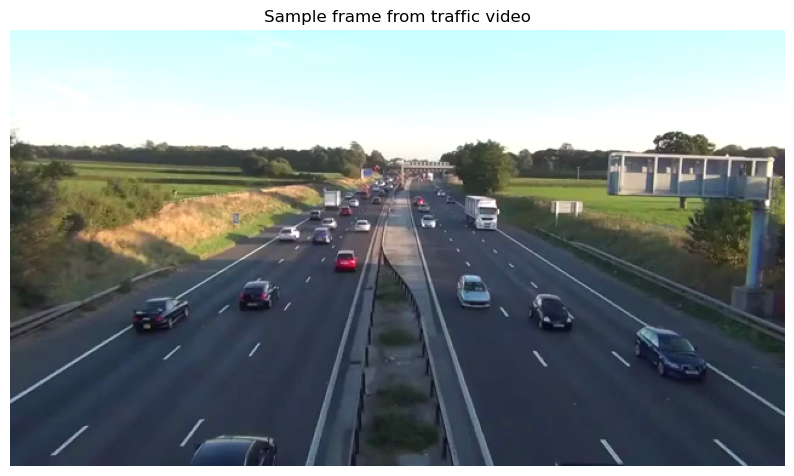

In [4]:
# Traffic video URL
traffic_url = "https://github.com/ezponda/intro_deep_learning/raw/main/images/road_traffic_video_for_object_recognition_short.mp4"

# Extract one frame for demonstration
cap = cv2.VideoCapture(traffic_url)
success, frame = cap.read()
cap.release()

if success:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(frame_rgb)
    plt.title("Sample frame from traffic video")
    plt.axis("off")
    plt.show()
else:
    print("Failed to read video. Check the URL or network connection.")

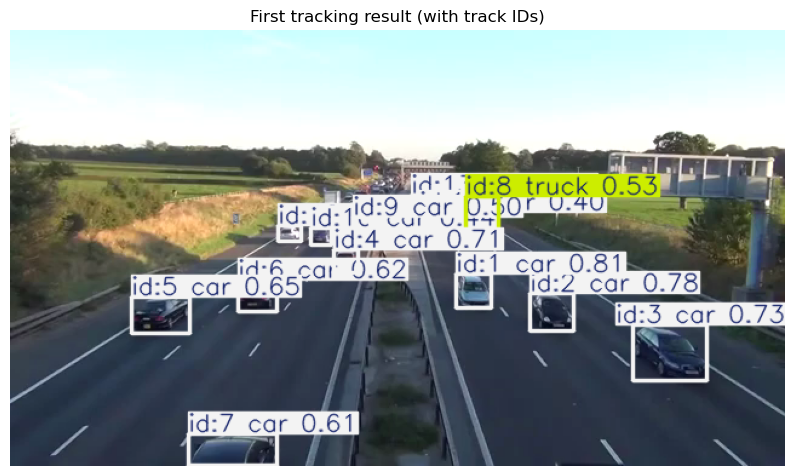

In [5]:
# Run tracking on the single frame
results = model.track(frame, persist=True, verbose=False)
result = results[0]

# Display annotated frame
annotated = result.plot()
annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(annotated_rgb)
plt.title("First tracking result (with track IDs)")
plt.axis("off")
plt.show()

In [6]:
# Inspect the tracking results
print("Tracking results structure:")
print(f"  Classes detected: {result.boxes.cls.cpu().numpy()}")
print(f"  Track IDs: {result.boxes.id.cpu().numpy() if result.boxes.id is not None else 'None'}")
print(f"  Class names: {result.names}")

# List detections with their track IDs
print("\nDetected objects:")
for i, (cls_id, track_id) in enumerate(zip(result.boxes.cls, result.boxes.id)):
    cls_name = result.names[int(cls_id)]
    print(f"  {i+1}. {cls_name} (Track ID: {int(track_id)})")

Tracking results structure:
  Classes detected: [          2           2           2           2           2           2           2           7           2           2           2           2           2]
  Track IDs: [          1           2           3           4           5           6           7           8           9          10          11          12          13]
  Class names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glas

## Track IDs and Common Challenges

### What are Track IDs?

Each detected object receives a unique **track ID** that persists across frames. This ID allows us to:

- Count unique objects (not just total detections)
- Measure how long an object stays in view
- Analyze movement patterns and trajectories

### Accessing Track IDs

```python
result.boxes.id  # Tensor of track IDs (one per detection)
result.boxes.cls  # Class indices
result.boxes.xyxy  # Bounding box coordinates
```

### Common Issues

- **ID switches**: When two objects cross paths, the tracker may swap their IDs
- **Lost tracks**: If an object disappears for too long, it may get a new ID when it reappears
- **Fragmented tracks**: Same object might have multiple IDs if detection is intermittent

These issues are inherent to tracking algorithms and can be mitigated by tuning parameters or using more sophisticated trackers.

## Video Tracking Demo

Let's run tracking on the entire traffic video. The loop processes each frame, maintains track history, and displays the results.

In [7]:
# Full video tracking loop
cap = cv2.VideoCapture(traffic_url)

print("Running video tracking... Press 'q' to stop early.")

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    
    # Run tracking with persistence
    results = model.track(frame, persist=True, verbose=False)
    result = results[0]
    
    # Visualize results
    annotated = result.plot()
    show_frame(annotated)
    
    # Exit on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Video tracking completed.")

Running video tracking... Press 'q' to stop early.
Video tracking completed.


### Optional: Webcam Tracking

If you have a webcam, you can try real-time tracking. This works in local environments but not in hosted notebooks like Colab.

In [8]:
# Optional: Webcam tracking (uncomment to use)
# Requires local environment with webcam access

# cap = cv2.VideoCapture(0)  # 0 = default webcam
# print("Webcam tracking... Press 'q' to stop.")
#
# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break
#     
#     results = model.track(frame, persist=True, verbose=False)
#     annotated = results[0].plot()
#     
#     cv2.imshow("Webcam Tracking", annotated)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
#
# cap.release()
# cv2.destroyAllWindows()

print("Webcam code is commented out. Uncomment to try real-time tracking.")

Webcam code is commented out. Uncomment to try real-time tracking.


## Counting Objects with a Region of Interest (ROI)

A common use case for tracking is counting objects that pass through a specific area. We define a **Region of Interest (ROI)** as a rectangle and count unique objects whose centers fall within it.

### Why Use an ROI?

- Count vehicles crossing a specific road section
- Monitor entries/exits at a gate or door
- Focus on relevant areas while ignoring distractions

In [9]:
class SimpleObjectCounter:
    """
    Count unique objects passing through a region of interest.
    """
    
    def __init__(self, roi, class_names=None):
        """
        Args:
            roi: Tuple (x1, y1, x2, y2) defining the rectangular region
            class_names: List of class names to count, or None for all classes
        """
        self.roi = roi
        self.class_names = class_names
        self.unique_objects = {}  # {class_name: set of track_ids}
    
    def is_in_roi(self, box):
        """Check if box center is within ROI."""
        x_center = (box[0] + box[2]) / 2
        y_center = (box[1] + box[3]) / 2
        return (self.roi[0] < x_center < self.roi[2] and 
                self.roi[1] < y_center < self.roi[3])
    
    def update(self, result):
        """Update counts based on tracking results."""
        if result.boxes.id is None:
            return
        
        for i in range(len(result.boxes)):
            box = result.boxes.xyxy[i].cpu().numpy()
            track_id = int(result.boxes.id[i])
            cls_name = result.names[int(result.boxes.cls[i])]
            
            if self.is_in_roi(box):
                if self.class_names is None or cls_name in self.class_names:
                    if cls_name not in self.unique_objects:
                        self.unique_objects[cls_name] = set()
                    self.unique_objects[cls_name].add(track_id)
    
    def get_counts(self):
        """Return dictionary of counts per class."""
        return {cls: len(ids) for cls, ids in self.unique_objects.items()}

In [10]:
# Define ROI and classes to count
roi = (100, 150, 500, 350)  # (x1, y1, x2, y2)
classes_to_count = ['truck', 'car', 'bus']

counter = SimpleObjectCounter(roi, classes_to_count)

# Run tracking with counting
cap = cv2.VideoCapture(traffic_url)
print(f"Counting objects in ROI: {roi}")
print(f"Classes: {classes_to_count}")
print("Running... Press 'q' to stop early.")

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    
    results = model.track(frame, persist=True, verbose=False)
    result = results[0]
    
    # Update counter
    counter.update(result)
    
    # Display with ROI
    annotated = result.plot()
    
    # Add count overlay
    counts = counter.get_counts()
    y_pos = 30
    for cls_name, count in counts.items():
        text = f"{cls_name}: {count}"
        cv2.putText(annotated, text, (10, y_pos), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
        y_pos += 30
    
    show_frame(annotated, roi)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

print("\nFinal counts:")
for cls_name, count in counter.get_counts().items():
    print(f"  {cls_name}: {count} unique objects")

Counting objects in ROI: (100, 150, 500, 350)
Classes: ['truck', 'car', 'bus']
Running... Press 'q' to stop early.

Final counts:
  car: 92 unique objects
  truck: 42 unique objects
  bus: 25 unique objects


## Exercises: Unique IDs and Lane-wise Counts

### Exercise 1: Count Unique Trucks

Count the number of **unique trucks** (by track ID) that appear anywhere in the video.

In [ ]:
# Exercise 1: Count unique trucks in the video

cap = cv2.VideoCapture(traffic_url)
unique_truck_ids = set()

print("Counting unique trucks... Press 'q' to stop early.")

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    
    results = model.track(frame, persist=True, verbose=False)
    result = results[0]
    
    # TODO: Loop over detections and add truck track IDs to unique_truck_ids
    # Hint: Use result.names to map class IDs to names (e.g., 'truck')
    # Hint: Use result.boxes.id to get track IDs
    # Hint: Check if result.boxes.id is not None before accessing it
    
    pass  # Your code here
    
    annotated = result.plot()
    show_frame(annotated)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

print(f"\nTotal unique trucks: {len(unique_truck_ids)}")

Counting unique trucks... Press 'q' to stop early.


### Exercise 2: Lane-wise Truck Counts

Count trucks passing through two different lanes (left and right) by defining two separate ROIs.

In [ ]:
# First, visualize the last frame to help define ROIs
cap = cv2.VideoCapture(traffic_url)
last_frame = None
while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break
    last_frame = frame
cap.release()

if last_frame is not None:
    plt.figure(figsize=(12, 7))
    plt.imshow(cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB))
    plt.title("Reference frame for defining lane ROIs")
    plt.axis("on")  # Keep axis to see coordinates
    plt.show()
    print(f"Frame size: {last_frame.shape[1]} x {last_frame.shape[0]}")

In [ ]:
# Exercise 2: Count trucks per lane

# TODO: Define ROIs for left and right lanes based on the reference frame above
# Hint: ROI format is (x1, y1, x2, y2) where (x1, y1) is top-left corner
left_lane_roi = None  # Replace with actual coordinates
right_lane_roi = None  # Replace with actual coordinates

# TODO: Create two SimpleObjectCounter instances, one for each lane
# Hint: SimpleObjectCounter(roi, ['truck'])
left_counter = None  # Your counter here
right_counter = None  # Your counter here

# TODO: Run tracking loop and update both counters
# Hint: Call counter.update(result) for each counter
# Hint: Draw both ROIs on the annotated frame using cv2.rectangle

pass  # Your tracking loop here

# TODO: Print final counts
# Hint: Use counter.get_counts().get('truck', 0) to get truck count
# Calculate and print: left lane trucks, right lane trucks, difference

pass  # Your print statements here

## Recap

### Key Takeaways

- **Object tracking** extends detection by maintaining consistent IDs across frames
- **Tracking-by-detection** runs a detector on each frame and associates detections over time
- **Track IDs** (`result.boxes.id`) uniquely identify each object throughout a video
- **`model.track(..., persist=True)`** maintains tracking history between calls
- **Tracking algorithms** (BoT-SORT, ByteTrack) differ in how they handle occlusions and associations
- **Region of Interest (ROI)** allows focused counting in specific image areas
- **Unique object counting** uses track IDs to avoid double-counting the same object
- **Common challenges**: Occlusion, ID switches, missed detections, objects entering/leaving the scene